In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
import re
import time
from datetime import timedelta
from openpyxl import Workbook, load_workbook
import os

In [4]:
def create_graph(edges):
    # Create an undirected graph
    graph = nx.Graph()            
        
    # Add edges to the graph
    # You can customize this part based on your specific graph or load it from external data
    graph.add_edges_from(edges)

    return graph

def create_neg_graph(g):
    # Create an undirected graph
    graph = nx.Graph()  
    
    
    edges = []
    
    for node in g:
        for nei, sign in g[node]:
            if sign != 1:
                edge = (node, nei)
                edges.append(edge)
        
    # Add edges to the graph
    # You can customize this part based on your specific graph or load it from external data
    graph.add_edges_from(edges)

    return graph

def preparing_edges_to_visualize(file_path):
    edges = []
    with open(file_path, "r") as file:
        for line in file:
            #u, v, sign = map(int, line.strip().split("\t"))
            u, v, sign = map(int, re.split(r'\t|\s+', line.strip()))
            edges.append((u, v, {'sign': sign}))
    return edges


def calculate_delta(graph, upper_bounds):
    delta_values = {}
    # Calculate delta for each vertex
    for node in graph.nodes():
        degree = graph.degree(node)
        upper_bound = upper_bounds[node]
        delta = degree - upper_bound
        delta_values[node] = delta

    return delta_values

def create_bipartite_graph(node, delta, degree, combined_bipartite_edges, graph_dict):

    bipartite_graph = nx.Graph()

    # Add nodes to the first class
    # range starts from node value to node+delta value
    
    delta_node_names = []
    
    
    for i in range(0, delta):
        if i != 0:
            delta_node_name = str(node) + "." + str(i)
            delta_node_names.append(delta_node_name)
        else:
            delta_node_names.append(node)
    
    bipartite_graph.add_nodes_from(delta_node_names, bipartite=0)


    # Add nodes to the second class
    bipartite_graph.add_nodes_from(graph_dict[str(node)], bipartite=1)

    # Add edges between nodes of opposite classes
    bipartite_graph.add_edges_from([(delta_node, degree_node) for delta_node in delta_node_names for degree_node in graph_dict[str(node)]])
    
    #getting edges from eact subgraphs
    for primary_edge, secondary_edge in bipartite_graph.edges():
        edge = (primary_edge, (str(node) +","+ str(secondary_edge)))
            
        #appending edges
        combined_bipartite_edges.append(edge)
        
    ################# The below is explaination of combined bipartite graph namings #####################

    ### Namings
    # Delta node represented with "." (eg: "1.2", "1.3", "1.4")
    # bipartited-degree-nodes represented with "," (eg: "1,2" "1,3" "1,4")

    # in bipartited graph we connect delta node with degree node
    # for combining bipartited graph with other bipartited graph we connect degree node 
    # with degree node (eg: "3,1" connect with "1,3")

        
    return (bipartite_graph, node)


def display_all_bipartite_graphs(bipartite_graphs, n):
    
    plt.figure(figsize=(12, 8))
    
    for i, (bipartite_graph, node) in enumerate(bipartite_graphs):
        plt.subplot(int(len(n)/2), 3, i + 1)
        pos = nx.spring_layout(bipartite_graph)
        nx.draw(bipartite_graph, pos, with_labels=True, font_weight='bold', node_color=['skyblue' if bipartite == 0 else 'lightcoral' for bipartite in nx.get_node_attributes(bipartite_graph, 'bipartite').values()], node_size=500, edgecolors='black', linewidths=1.0)
        plt.title(f"Bipartite Graph for Node {node}")

    plt.show()

In [5]:
def read_signed_graph_from_file(file_path):
    graph_dict = {}
    
    original_graph = []
    
    with open(file_path, 'r') as file:
        for line in file:
            source, target, weight = map(int, line.strip().split())
            original_graph.append((source, target, {"sign": weight}))
            
            if source not in graph_dict:
                graph_dict[source] = []
            if target not in graph_dict:
                graph_dict[target] = []
            graph_dict[source].append((target, weight))
            graph_dict[target].append((source, weight))
    return graph_dict, original_graph

def finding_positive_and_negative_neighbours(g):
    
    all_pos_connections = {}
    all_neg_connections = {}
    
    for node in g:
        pos_nei = []
        neg_nei = []
        
        for nei, sign in g[node]:
            if sign == 1:
                pos_nei.append(nei)
            elif sign == -1:
                neg_nei.append(nei)
            
        all_pos_connections[node] = {"neighbour": pos_nei}
        all_neg_connections[node] = {"neighbour": neg_nei}
        
        
        all_pos_connections[node]['total_count'] = len(pos_nei)
        all_neg_connections[node]['total_count'] = len(neg_nei)
        
        
        all_pos_connections[node]['inside_d_count'] = 0
        all_neg_connections[node]['inside_d_count'] = 0
        
        all_pos_connections[node]['inside_d_neighbour'] = []
        all_neg_connections[node]['inside_d_neighbour'] = []
    
#     for node in g:
#         all_pos_connections[node]['total_count'] = len(all_pos_connections[node]['neighbour'])
#         all_pos_connections[node]['inside_d_count'] = 0
        
#         all_neg_connections[node]['total_count'] = len(all_neg_connections[node]['neighbour'])
#         all_neg_connections[node]['inside_d_count'] = 0
    
    
    return all_pos_connections, all_neg_connections
            
    
def pos_neg_inside_d_or_not(d, all_positive, all_negative):
    all_pos = all_positive.copy()
    all_neg = all_negative.copy()
    b = []
    
    for node in d:
        to_check = [elem for elem in d if elem != node]
        
        if node in all_pos and 'neighbour' in all_pos[node] and node in all_neg and 'neighbour' in all_neg[node]:
        
            for checking_value in to_check:
            
                if checking_value in all_pos[node]['neighbour']:
                    all_pos[node]['total_count'] -= 1
                    all_pos[node]['inside_d_count'] += 1
                    all_pos[node]['neighbour'].remove(checking_value)
                    all_pos[node]['inside_d_neighbour'].append(checking_value) 
                    
                elif checking_value in all_neg[node]['neighbour']:
                    all_neg[node]['total_count'] -= 1
                    all_neg[node]['inside_d_count'] += 1
                    all_neg[node]['neighbour'].remove(checking_value)
                    all_neg[node]['inside_d_neighbour'].append(checking_value)
                
            node_max_neg_count = 0
            node_max_neg_count = max(all_neg[node]['total_count'], all_neg[node]['inside_d_count'])
        
            if (all_pos[node]['inside_d_count'] + 1) < node_max_neg_count:
                b.append(node)
    
    return b, all_pos, all_neg


def check_upper_bound(graph, b, all_pos, all_neg):
    upper_bound = {}
    
    for node in graph:
        if node not in b:
            upper_bound[node] = 0
        else:
            b1 = all_neg[node]['total_count'] - all_pos[node]['inside_d_count'] - 1
            
            b2 = math.ceil((all_neg[node]['inside_d_count'] - all_pos[node]['inside_d_count'] - 1) / 2)
            
            upper_bound[node] = max(b1, b2)
            
    return upper_bound

def find_max_edge(matching):
    
    edges_check = []
    
    for node, nei in matching:  
        vertex1 = str(node).split(',')
        vertex2 = str(nei).split(',')[::-1]
        
        if len(vertex1) == len(vertex2):
            if vertex1[0] == vertex2[0] and vertex1[1] == vertex2[1]:
                if int(vertex1[0]) < int(vertex1[1]):
                    edges_check.append(( int(vertex1[0]), int(vertex1[1])))
                else:
                    edges_check.append(( int(vertex1[1]), int(vertex1[0])))
                    
    unique_edges = list(set(edges_check))
                    
    return unique_edges
    
    
def finding_bipratie_graph_connecting_edges(combined_bipartite_edges):
    connecting = []
    rev_nodes = []

    # Iterate through the list to build mappings
    for node1, node2 in combined_bipartite_edges: 
        
        rev_node = (str(node2)[::-1])
        edge_set = (node2, rev_node)
        if rev_node not in rev_nodes:
            if edge_set not in connecting:
                connecting.append((node2, rev_node))
                rev_nodes.append(rev_node)
                rev_nodes.append(node2)
                
    return connecting
    
### Reduction part
    
def form_s(neg_neighbors_in_d, neg_neighbors_out_d, z, node):
    
    nei_in_d = []
    nei_out_d = []
    
    formed_s = []
    
    for nei in neg_neighbors_in_d:
        nei_in_d.append((node, nei))
        
        
    for nei in neg_neighbors_out_d:
        nei_out_d.append((node, nei))
        
    
    for values in nei_in_d:
        formed_s.append(values)
    
    for idx, values in enumerate(nei_out_d):
        if idx < z:
            formed_s.append(nei_out_d[idx])
     
    return formed_s, nei_in_d, nei_out_d
    

def check_reduction(all_pos, all_neg, node):
    
    z =  all_neg[node]['total_count'] - all_pos[node]['inside_d_count'] - all_neg[node]['inside_d_count'] - 1
      
    s, nei_in_d, nei_out_d = [], [], []
    
    if z >= 0:
        s, nei_in_d, nei_out_d = form_s(all_neg[node]['inside_d_neighbour'], 
                    all_neg[node]['neighbour'],
                    z, node )
    return s, nei_in_d, nei_out_d


def visualize_UDCS_applied_graph(G, udcs_matching_edges):

    udcs_graph = nx.spring_layout(G)

    plt.figure(figsize=(8,6))

    nx.draw_networkx_nodes(G, udcs_graph, node_color="skyblue", node_size=500, edgecolors='black', linewidths=1.0)
    nx.draw_networkx_edges(G, udcs_graph, edgelist=udcs_matching_edges, edge_color='blue', width=3.0)
    nx.draw_networkx_labels(G, udcs_graph, font_size=12, font_color='black')

    plt.title("UDCS Applied - Original Graph")
    
    plt.show()
    
def reduction(udcs_matching_edges, all_positive_after_check, all_negative_after_check, upper_bounds_dict, b):
    
    deg_in_udcs_matching_edges = {}

    for node in b:
        deg_in_udcs_matching_edges[node] = 0
    
        for edge in udcs_matching_edges:
            vertex1, vertex2 = edge  # Unpack the edge tuple
            if node == vertex1 or node == vertex2:
                deg_in_udcs_matching_edges[node] += 1
    
            
    flipping_matching_edges = udcs_matching_edges.copy()

    for node in b:

        if deg_in_udcs_matching_edges[node] < upper_bounds_dict[node]:
        
            s, nei_in_d, nei_out_d = check_reduction(all_positive_after_check, all_negative_after_check, node)
            
            inequality_count = upper_bounds_dict[node] - deg_in_udcs_matching_edges[node]
            
            ## prioritizing edges to flip inside d. 
            idx = 0
            while inequality_count > 0:
                if idx > len(s) - 1:
                    break
                    
                if s[idx] not in udcs_matching_edges:
                    if s[idx] in nei_in_d:
                        flipping_matching_edges.append(s[idx])
                        inequality_count -= 1 
                idx += 1
                
            ## edges to flip 
            idx = 0 
            while inequality_count > 0:
                if idx > len(s) - 1:
                    break
                if s[idx] not in udcs_matching_edges:
                    flipping_matching_edges.append(s[idx])
                    inequality_count -= 1
                idx += 1
                
    return flipping_matching_edges
    
def add_entries_to_excel(entries, filepath):
    # If the file exists, load the existing workbook; otherwise, create a new workbook
    if os.path.exists(filepath):
        wb = load_workbook(filepath)
    else:
        wb = Workbook()
    
    # Select the active worksheet
    ws = wb.active
    
    # If the file is newly created, add column headers
    if not os.path.exists(filepath):
        ws.append(['Number of Vertex', 'Time without Visualization', 'Time with Visualization'])
    
    # Add entries
    ws.append(entries)
    
    # Save the workbook with the specified filepath
    wb.save(filepath)
    
def write_in_execl(filename, entries):
    # Specify the filepath where you want to save the Excel file
    filepath = os.getcwd() + '/'

    # Add entries to Excel file with the specified filepath
    add_entries_to_excel(entries, filepath + filename)
    
    
def run_building_defensive_alliance(graph, original_graph, start_time, d, k, n, case_type):

    
    # Find positive and negative edges and store the counts of degrees. 
    all_positive, all_negative = finding_positive_and_negative_neighbours(graph)

    # Find the B vertex get by checking conditions
    b, all_positive_after_check, all_negative_after_check = pos_neg_inside_d_or_not(d, all_positive, all_negative)

    my_graph = create_graph(original_graph)

    my_neg_graph = create_neg_graph(graph)

    # Check the upper boundary for each node and set the values Accordingly based on condition b1 and b2
    upper_bounds_dict = check_upper_bound(my_graph, b, all_positive_after_check, all_negative_after_check)



    # Making dictionary for other purpose
    graph_dict = {}

    for edge in original_graph:
        if edge[2]['sign'] != 1:
            graph_dict.setdefault(str(edge[0]), []).append(edge[1])
            graph_dict.setdefault(str(edge[1]), []).append(edge[0])

    # Convert values to sets to remove duplicate neighbors
    graph_dict = {key: list(set(value)) for key, value in graph_dict.items()}


    # Set upper bounds as node attributes
    nx.set_node_attributes(my_neg_graph, upper_bounds_dict, 'upper_bound')

    # Print the graph with upper degree constraints
    print("\nGraph with Upper Degree Constraints:")
    print(my_neg_graph.nodes(data=True))

    # Calculate delta values for each vertex
    delta_values_dict = calculate_delta(my_neg_graph, upper_bounds_dict)

    # Print the delta values for each vertex
    print("\nDelta Values:")
    print(delta_values_dict)

    # list to combine edges from original and sub graphs
    combined_bipartite_graph = []


    # Create bipartite graphs for each vertex
    bipartite_graphs = [create_bipartite_graph(node, 
                                           delta_values_dict[node], 
                                           my_neg_graph.degree(node), 
                                           combined_bipartite_graph,
                                           graph_dict) for node in my_neg_graph.nodes()]

    # Display individual bipartite graphs
    # display_all_bipartite_graphs(bipartite_graphs,  my_graph.nodes())


    # Create a dictionary to store same edge connections (eg, [(31, 13), (21, 12)])
    connecting_bipartite_edges = finding_bipratie_graph_connecting_edges(combined_bipartite_graph)
    # print(connecting_bipartite_edges)

    # combining bipartite graphs and connecting_bipartite_egdes 
    for edges in connecting_bipartite_edges:
        combined_bipartite_graph.append(edges)


    # Display the graph with connected bipartite subgraphs
    com_graph = create_graph(combined_bipartite_graph)
        
    # Example usage:
    matching = nx.algorithms.matching.max_weight_matching(com_graph, maxcardinality=False)
    # print("Matching:", matching)

    udcs_matching_edges = find_max_edge(matching)
    
    # performance time without visualization
    endtime_udcs_WoV = time.monotonic()
    
    
    visualize_UDCS_applied_graph(my_graph, udcs_matching_edges)
    # performance time with visualization
    endtime_udcs_WV = time.monotonic()

    # storing the performance time in a excel file
    filename = case_type+"_performance_check_UDCS.xlsx" 
    totaltime_udcs_WoV, totaltime_udcs_WV = timedelta(seconds=endtime_udcs_WoV - start_time), timedelta(seconds=endtime_udcs_WV - start_time)
    udcs_performance_entries = n, totaltime_udcs_WoV, totaltime_udcs_WV
    write_in_execl(filename, udcs_performance_entries)

    print("\nUDCS Matching Edges are: ", udcs_matching_edges)

    flipping_matching_edges = reduction(udcs_matching_edges, all_positive_after_check, all_negative_after_check, upper_bounds_dict, b)

    print("\nPossible Flippable Edges are :", flipping_matching_edges)

    if len(flipping_matching_edges) <= k and len(flipping_matching_edges) > 0:
        print(f"\nBuilding defensive alliance by flipping atmost {k} edges is possible")
    else:
        print(f"\nBuilding defensive alliance by flipping atmost {k} edges is not possible")
    
    # storing the performance time in a excel file
    endtime_BDA = time.monotonic()
    filename = case_type+"_performance_check_BDA.xlsx" 
    totaltime_BDA = timedelta(seconds=endtime_BDA - start_time)
    BDA_performance_entries = n, totaltime_BDA, "-"
    write_in_execl(filename, BDA_performance_entries)
    
    

def erdos_renyi_signed_graph(num_nodes, avg_degree):
    # Generate a random graph using Erdős-Rényi model
    G = nx.erdos_renyi_graph(num_nodes, avg_degree / (num_nodes - 1))
    
    # Assign random signs to the edges
    for u, v in G.edges():
        sign = random.choice([1, -1])
        G[u][v]["sign"] = sign
    
    return G

def convert_graph_to_dict(G):
    
    # making graph_dict for further purpose
    graph_dict = {}
    for u, v, sign in G.edges(data="sign"):
        if u not in graph_dict:
            graph_dict[u] = []
        if v not in graph_dict:
            graph_dict[v] = []
        graph_dict[u].append((v, sign))
        graph_dict[v].append((u, sign))
    
    return graph_dict
    

def visualize_signed_graph(G):
    
    # Visualize the graph with positive edges in green and negative edges in red
    pos_edges = [(u, v) for u, v, sign in G.edges(data="sign") if sign == 1]
    neg_edges = [(u, v) for u, v, sign in G.edges(data="sign") if sign == -1]

#     pos_nodes = set([u for u, v in pos_edges] + [v for u, v in pos_edges])
#     neg_nodes = set([u for u, v in neg_edges] + [v for u, v in neg_edges])

    pos = nx.spring_layout(G)
    
    plt.figure(figsize=(8,6))
    
    nx.draw_networkx_nodes(G, pos, nodelist=list(G.nodes()), node_color="white", node_size=500, edgecolors='black', linewidths=1.0)
#     nx.draw_networkx_nodes(G, pos, nodelist=neg_nodes, node_color="r", node_size=100)
    nx.draw_networkx_edges(G, pos, edgelist=pos_edges, edge_color="g")
    nx.draw_networkx_edges(G, pos, edgelist=neg_edges, edge_color="r")
    nx.draw_networkx_labels(G, pos,  font_size=12, font_color='black')
    
    plt.plot([0], color='green', label='Positive Connection')
    plt.plot([0], color='red', label='Negative Connection')

    # Adding legend
    plt.legend()

    plt.show()
    

def write_signed_graph_to_file(graph):
    current_date = datetime.datetime.now().strftime("%Y-%m-%d-%m-%s")
    filepath = r"/Users/mac/Desktop/Desktop/RCS_Signed_Graph/Meeting_1/generated_files/"
    filename = filepath + f"signed_graph_{current_date}.txt"
    
    with open(filename, 'w') as file:
        for u, v, data in graph.edges(data=True):
            sign = data.get('sign', 1)
            file.write(f"{u} {v} {sign}\n")
        
def create_graph_from_random_graph(G):
    
    # making graph_dict for further purpose
    graph_dict = {}
    original_graph = []
    for source, target, weight in G.edges(data="sign"):
        original_graph.append((source, target, {"sign": weight}))
        
        if source not in graph_dict:
            graph_dict[source] = []
        if target not in graph_dict:
            graph_dict[target] = []
        graph_dict[source].append((target, weight))
        graph_dict[target].append((source, weight))
    return graph_dict, original_graph
    

Please enter maximum number of nodes wanted to check: 250

Case 1: Same Vertex set and Same number of flip value

Case 2: Vertex set will increase by half of the previous set and number of flip value will increase by 1
Please enter whcih case want to check: 2

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (7, {'upper_bound': 0}), (1, {'upper_bound': 0}), (2, {'upper_bound': 0}), (9, {'upper_bound': 0}), (8, {'upper_bound': 0}), (5, {'upper_bound': 0}), (6, {'upper_bound': 0})]

Delta Values:
{0: 1, 7: 1, 1: 2, 2: 1, 9: 1, 8: 1, 5: 2, 6: 1}


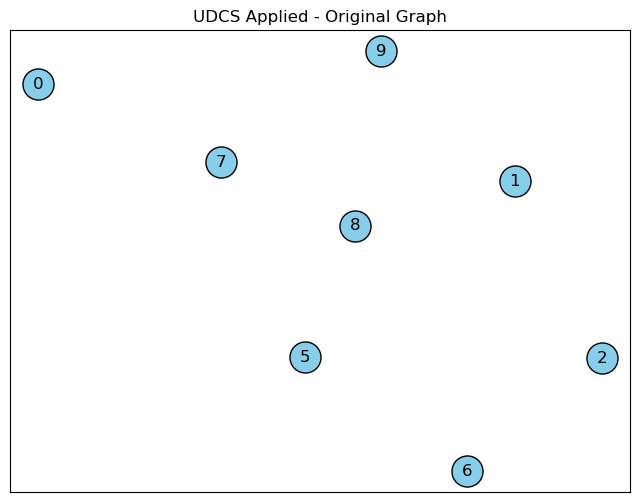


UDCS Matching Edges are:  []

Possible Flippable Edges are : []

Building defensive alliance by flipping atmost 2 edges is not possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (7, {'upper_bound': 0}), (9, {'upper_bound': 0}), (14, {'upper_bound': 0}), (12, {'upper_bound': 0}), (4, {'upper_bound': 1}), (5, {'upper_bound': 0}), (18, {'upper_bound': 0}), (10, {'upper_bound': 0}), (3, {'upper_bound': 3}), (8, {'upper_bound': 0}), (16, {'upper_bound': 0}), (15, {'upper_bound': 0}), (2, {'upper_bound': 0}), (6, {'upper_bound': 0}), (17, {'upper_bound': 0}), (13, {'upper_bound': 0}), (19, {'upper_bound': 0})]

Delta Values:
{0: 3, 7: 2, 9: 2, 14: 2, 12: 6, 4: 1, 5: 2, 18: 3, 10: 3, 3: 1, 8: 6, 16: 2, 15: 1, 2: 2, 6: 1, 17: 3, 13: 4, 19: 2}


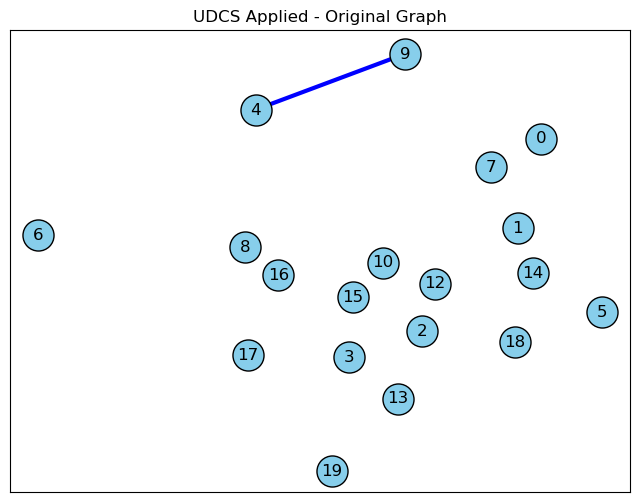


UDCS Matching Edges are:  [(4, 9)]

Possible Flippable Edges are : [(4, 9), (3, 10), (3, 16), (3, 17)]

Building defensive alliance by flipping atmost 3 edges is not possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (29, {'upper_bound': 0}), (11, {'upper_bound': 0}), (5, {'upper_bound': 0}), (17, {'upper_bound': 0}), (20, {'upper_bound': 0}), (24, {'upper_bound': 0}), (9, {'upper_bound': 2}), (18, {'upper_bound': 0}), (19, {'upper_bound': 0}), (25, {'upper_bound': 0}), (7, {'upper_bound': 2}), (22, {'upper_bound': 0}), (26, {'upper_bound': 0}), (3, {'upper_bound': 0}), (6, {'upper_bound': 1}), (1, {'upper_bound': 0}), (4, {'upper_bound': 0}), (23, {'upper_bound': 0}), (21, {'upper_bound': 0}), (12, {'upper_bound': 0}), (28, {'upper_bound': 0}), (2, {'upper_bound': 1}), (8, {'upper_bound': 0}), (27, {'upper_bound': 0}), (14, {'upper_bound': 0}), (15, {'upper_bound': 0}), (13, {'upper_bound': 0})]

Delta Values:
{0: 1, 29: 6, 11: 3, 5: 3, 17: 1, 20: 4, 24: 4, 9: 2

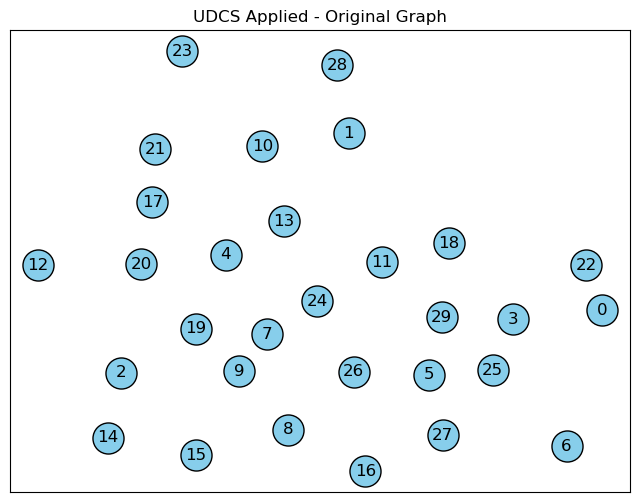


UDCS Matching Edges are:  []

Possible Flippable Edges are : [(7, 2), (7, 4), (9, 5), (9, 5)]

Building defensive alliance by flipping atmost 4 edges is possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (2, {'upper_bound': 2}), (4, {'upper_bound': 0}), (19, {'upper_bound': 0}), (27, {'upper_bound': 0}), (34, {'upper_bound': 0}), (39, {'upper_bound': 0}), (16, {'upper_bound': 0}), (36, {'upper_bound': 0}), (3, {'upper_bound': 0}), (8, {'upper_bound': 0}), (13, {'upper_bound': 0}), (32, {'upper_bound': 0}), (18, {'upper_bound': 0}), (5, {'upper_bound': 4}), (7, {'upper_bound': 2}), (30, {'upper_bound': 0}), (1, {'upper_bound': 2}), (24, {'upper_bound': 0}), (26, {'upper_bound': 0}), (28, {'upper_bound': 0}), (31, {'upper_bound': 0}), (6, {'upper_bound': 0}), (12, {'upper_bound': 0}), (21, {'upper_bound': 0}), (29, {'upper_bound': 0}), (38, {'upper_bound': 0}), (37, {'upper_bound': 0}), (33, {'upper_bound': 0}), (20, {'upper_bound': 0}), (9, {'upper_bound': 0}), (1

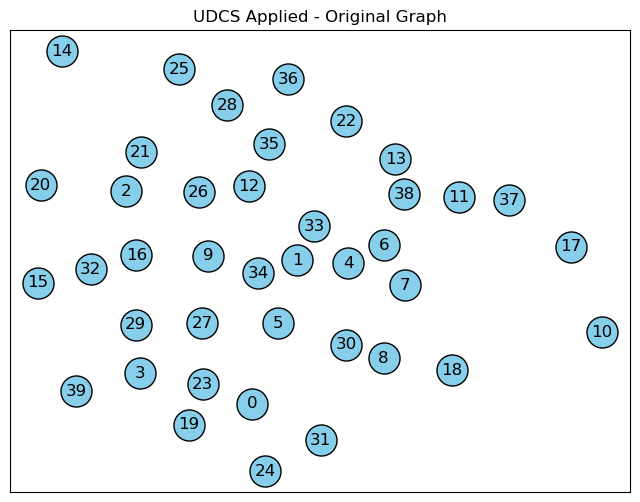


UDCS Matching Edges are:  []

Possible Flippable Edges are : [(2, 4), (2, 4), (5, 9), (5, 9), (5, 18), (5, 19), (7, 1), (7, 1)]

Building defensive alliance by flipping atmost 5 edges is not possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (14, {'upper_bound': 3}), (24, {'upper_bound': 0}), (27, {'upper_bound': 0}), (32, {'upper_bound': 0}), (9, {'upper_bound': 2}), (2, {'upper_bound': 0}), (5, {'upper_bound': 1}), (16, {'upper_bound': 1}), (30, {'upper_bound': 0}), (31, {'upper_bound': 0}), (41, {'upper_bound': 0}), (42, {'upper_bound': 0}), (45, {'upper_bound': 0}), (10, {'upper_bound': 1}), (1, {'upper_bound': 0}), (11, {'upper_bound': 1}), (17, {'upper_bound': 2}), (48, {'upper_bound': 0}), (12, {'upper_bound': 4}), (43, {'upper_bound': 0}), (21, {'upper_bound': 0}), (18, {'upper_bound': 1}), (20, {'upper_bound': 0}), (26, {'upper_bound': 0}), (15, {'upper_bound': 2}), (19, {'upper_bound': 1}), (49, {'upper_bound': 0}), (6, {'upper_bound': 0}), (8, {'upper_

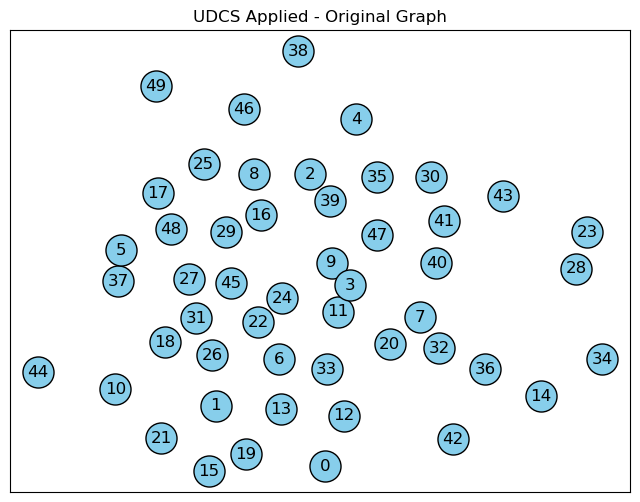


UDCS Matching Edges are:  []

Possible Flippable Edges are : [(3, 13), (3, 18), (8, 13), (14, 12), (14, 12), (14, 0), (17, 10), (17, 10), (19, 18)]

Building defensive alliance by flipping atmost 6 edges is not possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (16, {'upper_bound': 0}), (20, {'upper_bound': 0}), (23, {'upper_bound': 2}), (24, {'upper_bound': 0}), (28, {'upper_bound': 2}), (30, {'upper_bound': 0}), (31, {'upper_bound': 0}), (32, {'upper_bound': 0}), (33, {'upper_bound': 0}), (35, {'upper_bound': 0}), (42, {'upper_bound': 0}), (44, {'upper_bound': 0}), (45, {'upper_bound': 0}), (52, {'upper_bound': 0}), (5, {'upper_bound': 0}), (3, {'upper_bound': 0}), (17, {'upper_bound': 1}), (47, {'upper_bound': 0}), (51, {'upper_bound': 0}), (59, {'upper_bound': 0}), (8, {'upper_bound': 2}), (12, {'upper_bound': 1}), (19, {'upper_bound': 2}), (29, {'upper_bound': 0}), (46, {'upper_bound': 0}), (54, {'upper_bound': 0}), (56, {'upper_bound': 0}), (57, {'upper_bou

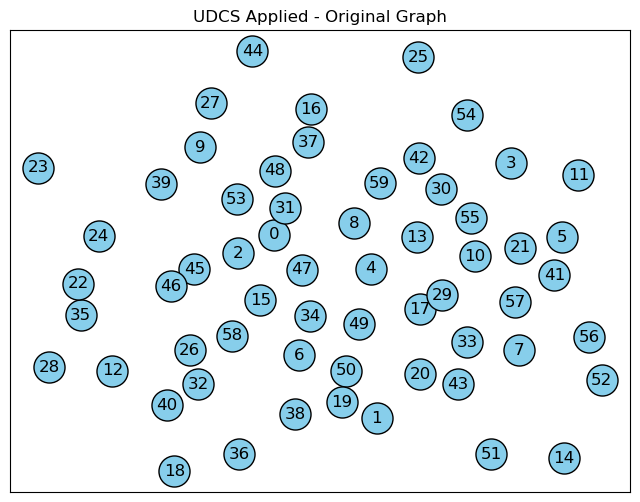


UDCS Matching Edges are:  []

Possible Flippable Edges are : [(2, 11), (2, 22), (2, 27), (2, 11), (2, 22), (2, 27), (7, 17), (7, 17), (7, 30), (7, 36), (13, 6), (13, 6), (13, 30), (13, 34), (13, 37), (23, 8), (23, 8), (26, 10), (26, 15), (26, 10), (28, 9), (28, 9)]

Building defensive alliance by flipping atmost 7 edges is not possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (14, {'upper_bound': 1}), (15, {'upper_bound': 0}), (25, {'upper_bound': 3}), (28, {'upper_bound': 2}), (33, {'upper_bound': 0}), (67, {'upper_bound': 0}), (69, {'upper_bound': 0}), (10, {'upper_bound': 1}), (3, {'upper_bound': 2}), (12, {'upper_bound': 2}), (13, {'upper_bound': 1}), (27, {'upper_bound': 3}), (46, {'upper_bound': 0}), (48, {'upper_bound': 0}), (53, {'upper_bound': 0}), (68, {'upper_bound': 0}), (5, {'upper_bound': 1}), (17, {'upper_bound': 0}), (66, {'upper_bound': 0}), (1, {'upper_bound': 1}), (8, {'upper_bound': 2}), (44, {'upper_bound': 0}), (45, {'upper_bound': 0}), (50

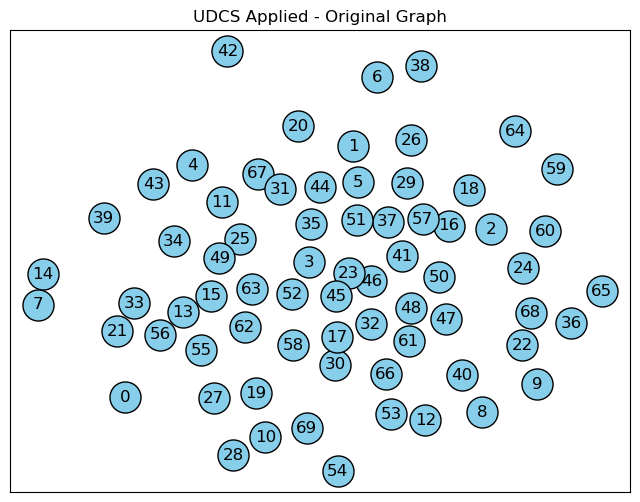


UDCS Matching Edges are:  []

Possible Flippable Edges are : []

Building defensive alliance by flipping atmost 8 edges is not possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (1, {'upper_bound': 0}), (4, {'upper_bound': 1}), (6, {'upper_bound': 0}), (12, {'upper_bound': 2}), (64, {'upper_bound': 0}), (9, {'upper_bound': 1}), (22, {'upper_bound': 0}), (35, {'upper_bound': 1}), (40, {'upper_bound': 0}), (48, {'upper_bound': 0}), (3, {'upper_bound': 0}), (11, {'upper_bound': 0}), (21, {'upper_bound': 2}), (28, {'upper_bound': 0}), (33, {'upper_bound': 0}), (43, {'upper_bound': 0}), (60, {'upper_bound': 1}), (65, {'upper_bound': 0}), (68, {'upper_bound': 0}), (77, {'upper_bound': 0}), (10, {'upper_bound': 3}), (14, {'upper_bound': 2}), (18, {'upper_bound': 1}), (25, {'upper_bound': 0}), (29, {'upper_bound': 0}), (36, {'upper_bound': 0}), (55, {'upper_bound': 0}), (70, {'upper_bound': 0}), (71, {'upper_bound': 0}), (74, {'upper_bound': 0}), (79, {'upper_bound': 0})

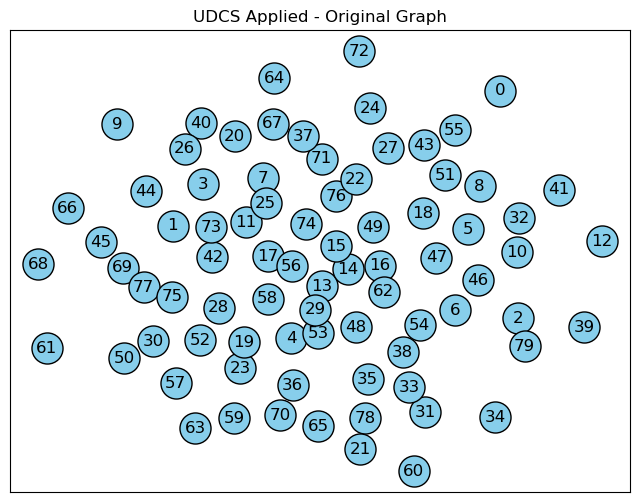


UDCS Matching Edges are:  []

Possible Flippable Edges are : []

Building defensive alliance by flipping atmost 9 edges is not possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (3, {'upper_bound': 0}), (4, {'upper_bound': 0}), (15, {'upper_bound': 0}), (16, {'upper_bound': 0}), (19, {'upper_bound': 0}), (24, {'upper_bound': 0}), (31, {'upper_bound': 0}), (37, {'upper_bound': 3}), (42, {'upper_bound': 0}), (46, {'upper_bound': 0}), (71, {'upper_bound': 1}), (79, {'upper_bound': 0}), (81, {'upper_bound': 1}), (86, {'upper_bound': 2}), (14, {'upper_bound': 0}), (51, {'upper_bound': 2}), (53, {'upper_bound': 0}), (54, {'upper_bound': 0}), (58, {'upper_bound': 0}), (64, {'upper_bound': 3}), (12, {'upper_bound': 0}), (41, {'upper_bound': 0}), (48, {'upper_bound': 1}), (60, {'upper_bound': 0}), (74, {'upper_bound': 0}), (10, {'upper_bound': 2}), (13, {'upper_bound': 3}), (27, {'upper_bound': 0}), (34, {'upper_bound': 2}), (70, {'upper_bound': 0}), (84, {'upper_bound': 

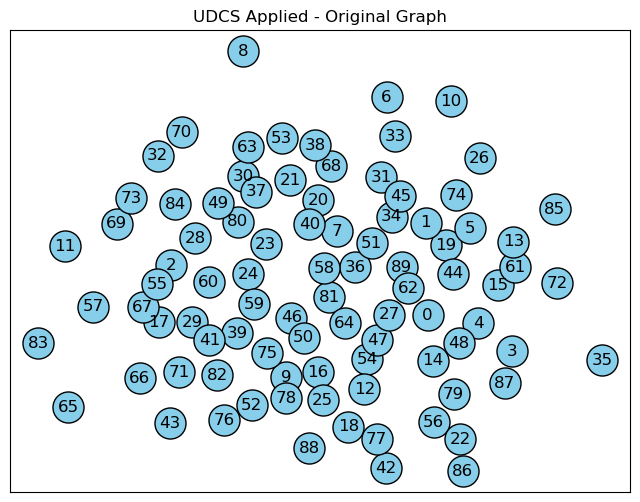


UDCS Matching Edges are:  []

Possible Flippable Edges are : []

Building defensive alliance by flipping atmost 10 edges is not possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (3, {'upper_bound': 5}), (10, {'upper_bound': 0}), (12, {'upper_bound': 1}), (23, {'upper_bound': 0}), (26, {'upper_bound': 0}), (60, {'upper_bound': 0}), (75, {'upper_bound': 0}), (92, {'upper_bound': 3}), (2, {'upper_bound': 0}), (25, {'upper_bound': 0}), (31, {'upper_bound': 0}), (42, {'upper_bound': 0}), (70, {'upper_bound': 3}), (87, {'upper_bound': 1}), (93, {'upper_bound': 0}), (96, {'upper_bound': 1}), (97, {'upper_bound': 2}), (4, {'upper_bound': 1}), (8, {'upper_bound': 0}), (27, {'upper_bound': 3}), (33, {'upper_bound': 2}), (48, {'upper_bound': 0}), (51, {'upper_bound': 0}), (61, {'upper_bound': 0}), (66, {'upper_bound': 3}), (68, {'upper_bound': 0}), (84, {'upper_bound': 0}), (85, {'upper_bound': 2}), (90, {'upper_bound': 0}), (1, {'upper_bound': 0}), (14, {'upper_bound': 0}

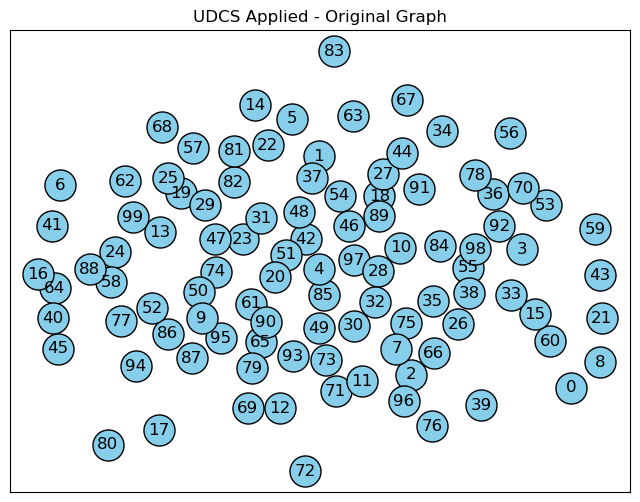


UDCS Matching Edges are:  []

Possible Flippable Edges are : []

Building defensive alliance by flipping atmost 11 edges is not possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (13, {'upper_bound': 0}), (26, {'upper_bound': 0}), (30, {'upper_bound': 0}), (33, {'upper_bound': 0}), (44, {'upper_bound': 0}), (51, {'upper_bound': 3}), (62, {'upper_bound': 0}), (73, {'upper_bound': 0}), (76, {'upper_bound': 0}), (81, {'upper_bound': 0}), (83, {'upper_bound': 0}), (95, {'upper_bound': 0}), (98, {'upper_bound': 0}), (5, {'upper_bound': 1}), (6, {'upper_bound': 0}), (24, {'upper_bound': 0}), (36, {'upper_bound': 0}), (56, {'upper_bound': 3}), (57, {'upper_bound': 3}), (67, {'upper_bound': 1}), (68, {'upper_bound': 3}), (69, {'upper_bound': 0}), (79, {'upper_bound': 0}), (100, {'upper_bound': 0}), (105, {'upper_bound': 0}), (1, {'upper_bound': 1}), (3, {'upper_bound': 0}), (9, {'upper_bound': 1}), (11, {'upper_bound': 1}), (12, {'upper_bound': 0}), (22, {'upper_bound': 

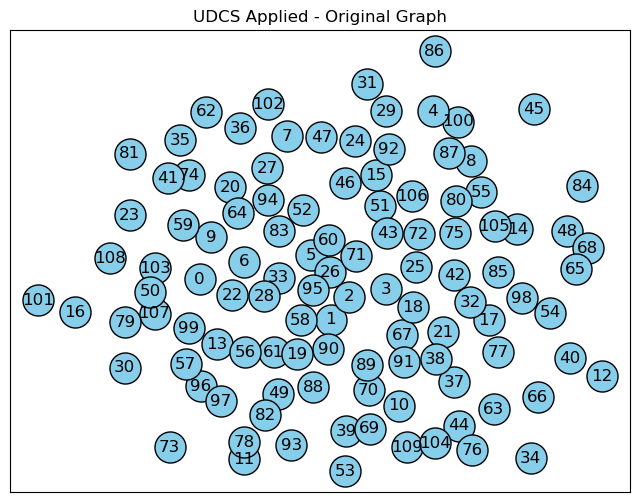


UDCS Matching Edges are:  []

Possible Flippable Edges are : []

Building defensive alliance by flipping atmost 12 edges is not possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (11, {'upper_bound': 2}), (16, {'upper_bound': 2}), (20, {'upper_bound': 3}), (27, {'upper_bound': 2}), (44, {'upper_bound': 2}), (58, {'upper_bound': 1}), (61, {'upper_bound': 0}), (74, {'upper_bound': 1}), (86, {'upper_bound': 2}), (93, {'upper_bound': 0}), (96, {'upper_bound': 0}), (7, {'upper_bound': 0}), (3, {'upper_bound': 0}), (23, {'upper_bound': 0}), (25, {'upper_bound': 0}), (32, {'upper_bound': 1}), (43, {'upper_bound': 0}), (64, {'upper_bound': 0}), (84, {'upper_bound': 2}), (90, {'upper_bound': 2}), (100, {'upper_bound': 0}), (5, {'upper_bound': 2}), (17, {'upper_bound': 0}), (33, {'upper_bound': 7}), (46, {'upper_bound': 4}), (48, {'upper_bound': 4}), (72, {'upper_bound': 2}), (76, {'upper_bound': 4}), (79, {'upper_bound': 4}), (80, {'upper_bound': 4}), (97, {'upper_bound':

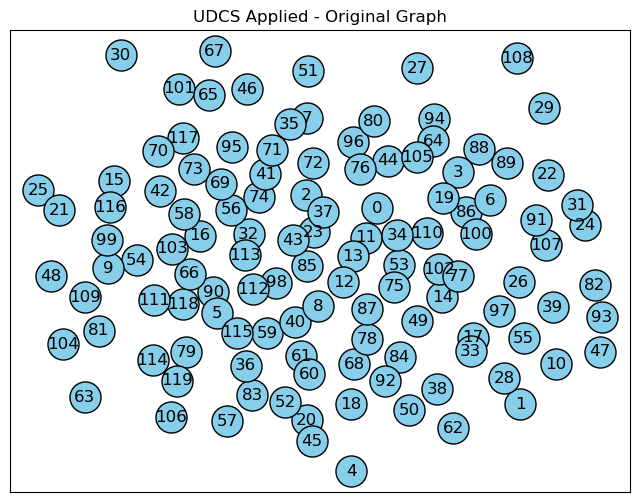


UDCS Matching Edges are:  []

Possible Flippable Edges are : []

Building defensive alliance by flipping atmost 13 edges is not possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (9, {'upper_bound': 0}), (25, {'upper_bound': 0}), (40, {'upper_bound': 0}), (52, {'upper_bound': 0}), (59, {'upper_bound': 0}), (86, {'upper_bound': 0}), (90, {'upper_bound': 0}), (97, {'upper_bound': 0}), (7, {'upper_bound': 0}), (10, {'upper_bound': 0}), (24, {'upper_bound': 5}), (41, {'upper_bound': 0}), (66, {'upper_bound': 0}), (99, {'upper_bound': 0}), (100, {'upper_bound': 2}), (102, {'upper_bound': 0}), (110, {'upper_bound': 0}), (121, {'upper_bound': 0}), (16, {'upper_bound': 0}), (22, {'upper_bound': 1}), (28, {'upper_bound': 0}), (36, {'upper_bound': 0}), (42, {'upper_bound': 0}), (56, {'upper_bound': 0}), (85, {'upper_bound': 2}), (87, {'upper_bound': 0}), (93, {'upper_bound': 0}), (13, {'upper_bound': 0}), (45, {'upper_bound': 0}), (48, {'upper_bound': 0}), (101, {'upper_bo

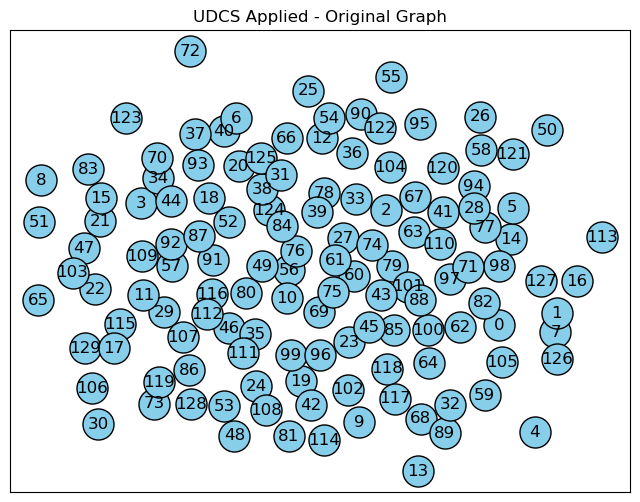


UDCS Matching Edges are:  []

Possible Flippable Edges are : []

Building defensive alliance by flipping atmost 14 edges is not possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (6, {'upper_bound': 0}), (17, {'upper_bound': 3}), (32, {'upper_bound': 0}), (63, {'upper_bound': 8}), (64, {'upper_bound': 3}), (71, {'upper_bound': 0}), (79, {'upper_bound': 0}), (95, {'upper_bound': 4}), (123, {'upper_bound': 0}), (125, {'upper_bound': 0}), (126, {'upper_bound': 0}), (10, {'upper_bound': 0}), (14, {'upper_bound': 3}), (40, {'upper_bound': 0}), (52, {'upper_bound': 4}), (60, {'upper_bound': 3}), (62, {'upper_bound': 0}), (119, {'upper_bound': 0}), (42, {'upper_bound': 0}), (55, {'upper_bound': 0}), (61, {'upper_bound': 0}), (86, {'upper_bound': 0}), (90, {'upper_bound': 2}), (93, {'upper_bound': 0}), (101, {'upper_bound': 0}), (105, {'upper_bound': 2}), (110, {'upper_bound': 0}), (120, {'upper_bound': 0}), (127, {'upper_bound': 0}), (12, {'upper_bound': 0}), (7, {'uppe

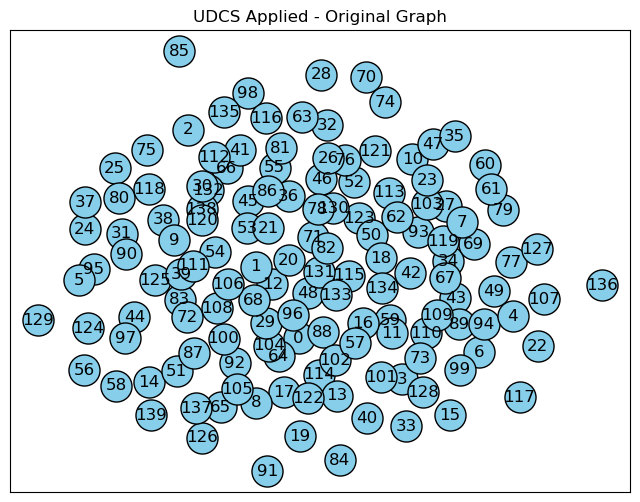


UDCS Matching Edges are:  []

Possible Flippable Edges are : []

Building defensive alliance by flipping atmost 15 edges is not possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (8, {'upper_bound': 2}), (9, {'upper_bound': 0}), (27, {'upper_bound': 2}), (39, {'upper_bound': 0}), (50, {'upper_bound': 0}), (67, {'upper_bound': 0}), (71, {'upper_bound': 1}), (91, {'upper_bound': 2}), (96, {'upper_bound': 4}), (100, {'upper_bound': 1}), (101, {'upper_bound': 0}), (107, {'upper_bound': 1}), (120, {'upper_bound': 0}), (124, {'upper_bound': 0}), (136, {'upper_bound': 0}), (149, {'upper_bound': 5}), (14, {'upper_bound': 0}), (21, {'upper_bound': 2}), (33, {'upper_bound': 0}), (44, {'upper_bound': 0}), (45, {'upper_bound': 3}), (47, {'upper_bound': 0}), (59, {'upper_bound': 0}), (63, {'upper_bound': 0}), (87, {'upper_bound': 0}), (109, {'upper_bound': 0}), (118, {'upper_bound': 1}), (132, {'upper_bound': 5}), (145, {'upper_bound': 5}), (32, {'upper_bound': 2}), (56, {'up

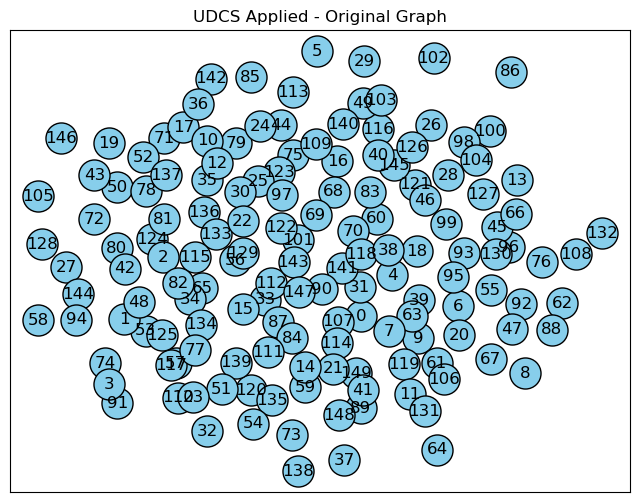


UDCS Matching Edges are:  []

Possible Flippable Edges are : []

Building defensive alliance by flipping atmost 16 edges is not possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (15, {'upper_bound': 0}), (34, {'upper_bound': 4}), (44, {'upper_bound': 0}), (48, {'upper_bound': 2}), (51, {'upper_bound': 0}), (58, {'upper_bound': 1}), (59, {'upper_bound': 0}), (84, {'upper_bound': 4}), (99, {'upper_bound': 1}), (118, {'upper_bound': 0}), (120, {'upper_bound': 4}), (152, {'upper_bound': 0}), (155, {'upper_bound': 3}), (8, {'upper_bound': 2}), (20, {'upper_bound': 3}), (25, {'upper_bound': 1}), (26, {'upper_bound': 4}), (31, {'upper_bound': 0}), (38, {'upper_bound': 0}), (49, {'upper_bound': 3}), (50, {'upper_bound': 3}), (68, {'upper_bound': 3}), (83, {'upper_bound': 2}), (95, {'upper_bound': 2}), (102, {'upper_bound': 5}), (109, {'upper_bound': 0}), (124, {'upper_bound': 1}), (136, {'upper_bound': 0}), (157, {'upper_bound': 2}), (18, {'upper_bound': 3}), (23, {'upp

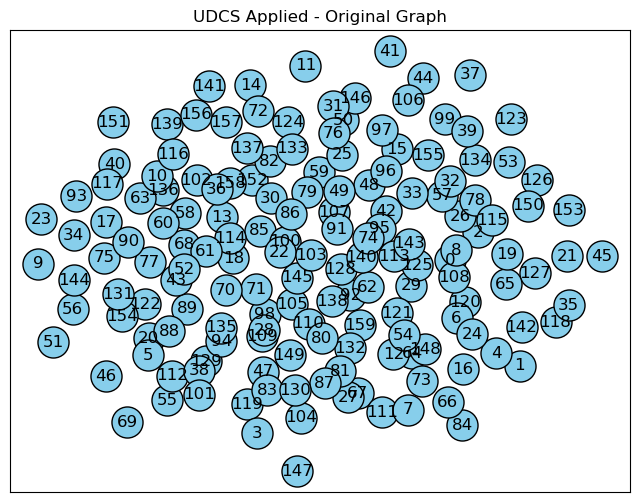


UDCS Matching Edges are:  []

Possible Flippable Edges are : []

Building defensive alliance by flipping atmost 17 edges is not possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (6, {'upper_bound': 0}), (10, {'upper_bound': 0}), (36, {'upper_bound': 5}), (49, {'upper_bound': 1}), (69, {'upper_bound': 0}), (71, {'upper_bound': 0}), (75, {'upper_bound': 0}), (78, {'upper_bound': 0}), (104, {'upper_bound': 0}), (115, {'upper_bound': 0}), (118, {'upper_bound': 0}), (127, {'upper_bound': 3}), (134, {'upper_bound': 4}), (148, {'upper_bound': 0}), (159, {'upper_bound': 2}), (164, {'upper_bound': 0}), (166, {'upper_bound': 0}), (9, {'upper_bound': 3}), (22, {'upper_bound': 0}), (31, {'upper_bound': 0}), (44, {'upper_bound': 0}), (57, {'upper_bound': 0}), (62, {'upper_bound': 0}), (63, {'upper_bound': 0}), (68, {'upper_bound': 2}), (86, {'upper_bound': 0}), (96, {'upper_bound': 4}), (150, {'upper_bound': 0}), (152, {'upper_bound': 0}), (169, {'upper_bound': 0}), (17, {'u

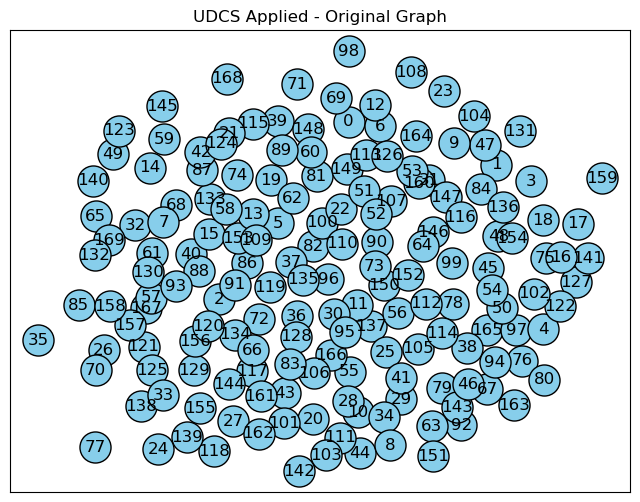


UDCS Matching Edges are:  []

Possible Flippable Edges are : []

Building defensive alliance by flipping atmost 18 edges is not possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (9, {'upper_bound': 1}), (29, {'upper_bound': 2}), (46, {'upper_bound': 2}), (54, {'upper_bound': 6}), (55, {'upper_bound': 3}), (60, {'upper_bound': 0}), (65, {'upper_bound': 0}), (66, {'upper_bound': 0}), (74, {'upper_bound': 2}), (77, {'upper_bound': 0}), (90, {'upper_bound': 4}), (96, {'upper_bound': 0}), (101, {'upper_bound': 0}), (111, {'upper_bound': 0}), (113, {'upper_bound': 2}), (116, {'upper_bound': 1}), (119, {'upper_bound': 0}), (121, {'upper_bound': 0}), (143, {'upper_bound': 1}), (146, {'upper_bound': 0}), (153, {'upper_bound': 5}), (159, {'upper_bound': 0}), (2, {'upper_bound': 0}), (8, {'upper_bound': 3}), (33, {'upper_bound': 1}), (68, {'upper_bound': 2}), (70, {'upper_bound': 4}), (73, {'upper_bound': 0}), (82, {'upper_bound': 0}), (84, {'upper_bound': 0}), (122, {'upp

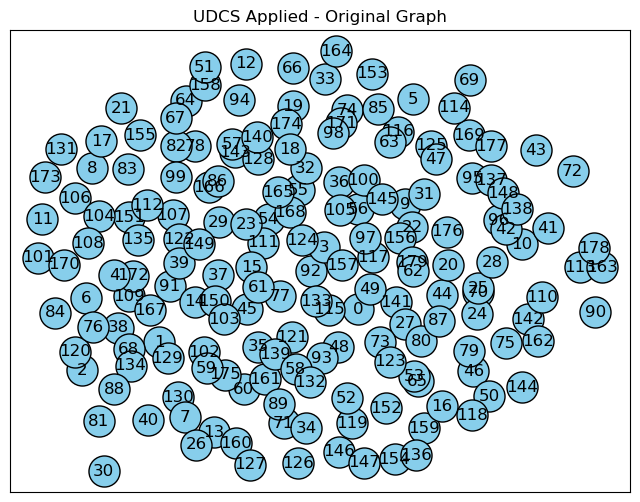


UDCS Matching Edges are:  []

Possible Flippable Edges are : []

Building defensive alliance by flipping atmost 19 edges is not possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (3, {'upper_bound': 0}), (6, {'upper_bound': 2}), (22, {'upper_bound': 0}), (28, {'upper_bound': 0}), (43, {'upper_bound': 0}), (54, {'upper_bound': 2}), (60, {'upper_bound': 2}), (69, {'upper_bound': 2}), (78, {'upper_bound': 1}), (86, {'upper_bound': 0}), (98, {'upper_bound': 0}), (125, {'upper_bound': 4}), (143, {'upper_bound': 5}), (150, {'upper_bound': 0}), (170, {'upper_bound': 0}), (176, {'upper_bound': 0}), (179, {'upper_bound': 0}), (186, {'upper_bound': 0}), (8, {'upper_bound': 0}), (50, {'upper_bound': 1}), (75, {'upper_bound': 0}), (79, {'upper_bound': 6}), (84, {'upper_bound': 2}), (90, {'upper_bound': 0}), (93, {'upper_bound': 0}), (96, {'upper_bound': 0}), (110, {'upper_bound': 5}), (124, {'upper_bound': 4}), (127, {'upper_bound': 3}), (130, {'upper_bound': 2}), (137, {'up

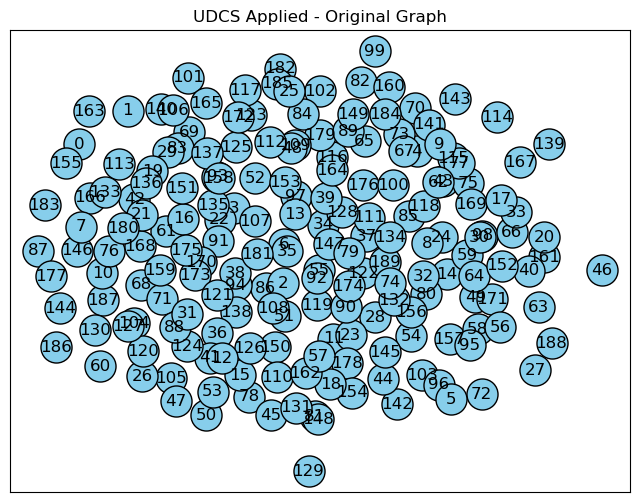


UDCS Matching Edges are:  []

Possible Flippable Edges are : []

Building defensive alliance by flipping atmost 20 edges is not possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (1, {'upper_bound': 0}), (29, {'upper_bound': 6}), (41, {'upper_bound': 3}), (62, {'upper_bound': 2}), (80, {'upper_bound': 0}), (99, {'upper_bound': 1}), (107, {'upper_bound': 6}), (130, {'upper_bound': 0}), (134, {'upper_bound': 0}), (140, {'upper_bound': 3}), (146, {'upper_bound': 0}), (158, {'upper_bound': 2}), (163, {'upper_bound': 3}), (165, {'upper_bound': 0}), (173, {'upper_bound': 2}), (189, {'upper_bound': 4}), (18, {'upper_bound': 3}), (36, {'upper_bound': 0}), (37, {'upper_bound': 2}), (56, {'upper_bound': 0}), (58, {'upper_bound': 0}), (63, {'upper_bound': 2}), (77, {'upper_bound': 2}), (92, {'upper_bound': 0}), (102, {'upper_bound': 5}), (116, {'upper_bound': 0}), (122, {'upper_bound': 4}), (127, {'upper_bound': 0}), (132, {'upper_bound': 7}), (147, {'upper_bound': 2}), (9,

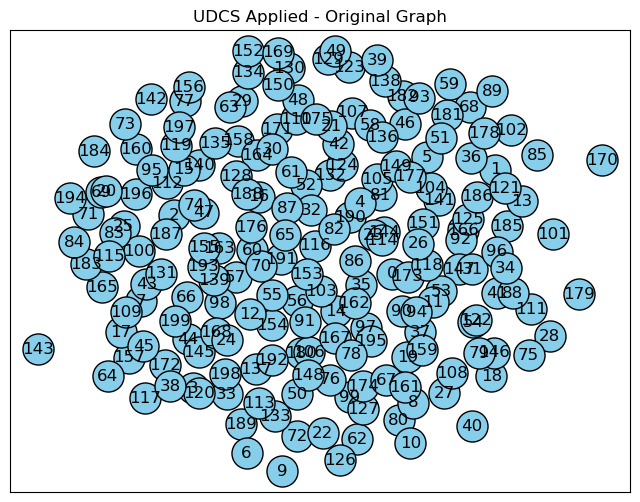


UDCS Matching Edges are:  []

Possible Flippable Edges are : []

Building defensive alliance by flipping atmost 21 edges is not possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (11, {'upper_bound': 0}), (21, {'upper_bound': 0}), (23, {'upper_bound': 0}), (27, {'upper_bound': 4}), (30, {'upper_bound': 0}), (34, {'upper_bound': 0}), (47, {'upper_bound': 1}), (49, {'upper_bound': 0}), (50, {'upper_bound': 1}), (54, {'upper_bound': 1}), (73, {'upper_bound': 0}), (78, {'upper_bound': 2}), (82, {'upper_bound': 0}), (89, {'upper_bound': 2}), (91, {'upper_bound': 0}), (92, {'upper_bound': 0}), (101, {'upper_bound': 2}), (106, {'upper_bound': 0}), (124, {'upper_bound': 3}), (128, {'upper_bound': 1}), (130, {'upper_bound': 2}), (145, {'upper_bound': 2}), (154, {'upper_bound': 0}), (164, {'upper_bound': 4}), (165, {'upper_bound': 5}), (176, {'upper_bound': 1}), (200, {'upper_bound': 0}), (1, {'upper_bound': 0}), (29, {'upper_bound': 2}), (35, {'upper_bound': 0}), (52, {'u

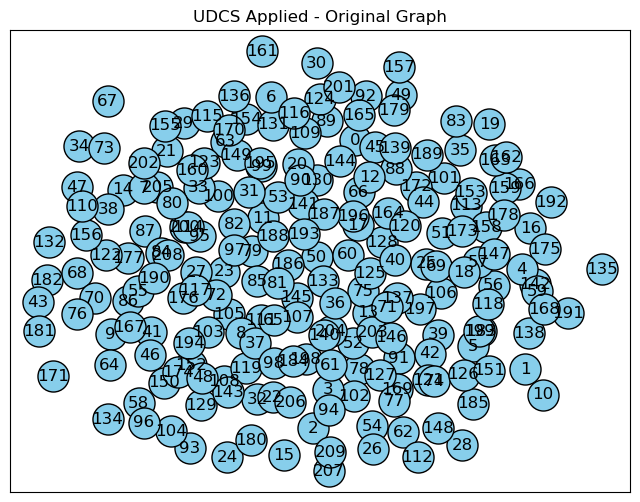


UDCS Matching Edges are:  []

Possible Flippable Edges are : []

Building defensive alliance by flipping atmost 22 edges is not possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (23, {'upper_bound': 0}), (28, {'upper_bound': 1}), (31, {'upper_bound': 11}), (37, {'upper_bound': 0}), (56, {'upper_bound': 0}), (61, {'upper_bound': 0}), (62, {'upper_bound': 0}), (71, {'upper_bound': 0}), (75, {'upper_bound': 6}), (80, {'upper_bound': 0}), (86, {'upper_bound': 2}), (93, {'upper_bound': 0}), (94, {'upper_bound': 0}), (102, {'upper_bound': 2}), (103, {'upper_bound': 1}), (106, {'upper_bound': 0}), (167, {'upper_bound': 3}), (180, {'upper_bound': 0}), (182, {'upper_bound': 4}), (184, {'upper_bound': 0}), (193, {'upper_bound': 0}), (199, {'upper_bound': 0}), (209, {'upper_bound': 0}), (22, {'upper_bound': 4}), (8, {'upper_bound': 0}), (12, {'upper_bound': 4}), (14, {'upper_bound': 0}), (33, {'upper_bound': 0}), (41, {'upper_bound': 1}), (43, {'upper_bound': 1}), (54, {'u

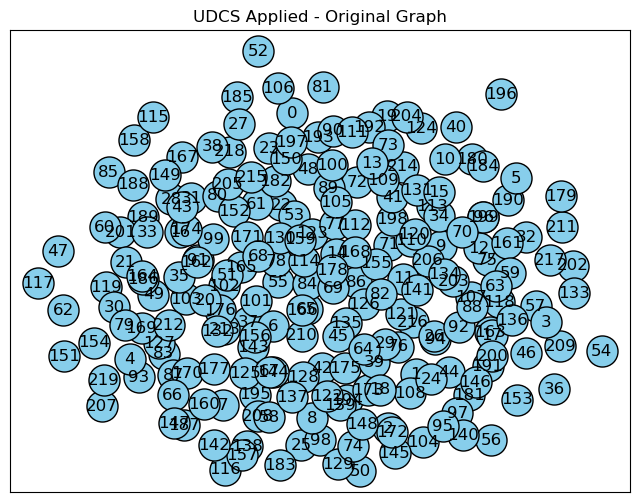


UDCS Matching Edges are:  []

Possible Flippable Edges are : []

Building defensive alliance by flipping atmost 23 edges is not possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (17, {'upper_bound': 5}), (20, {'upper_bound': 0}), (22, {'upper_bound': 0}), (23, {'upper_bound': 0}), (35, {'upper_bound': 10}), (47, {'upper_bound': 4}), (69, {'upper_bound': 2}), (85, {'upper_bound': 0}), (106, {'upper_bound': 0}), (114, {'upper_bound': 0}), (131, {'upper_bound': 1}), (134, {'upper_bound': 0}), (145, {'upper_bound': 0}), (168, {'upper_bound': 0}), (174, {'upper_bound': 0}), (179, {'upper_bound': 4}), (184, {'upper_bound': 0}), (196, {'upper_bound': 0}), (213, {'upper_bound': 1}), (217, {'upper_bound': 0}), (11, {'upper_bound': 4}), (12, {'upper_bound': 0}), (16, {'upper_bound': 3}), (18, {'upper_bound': 0}), (25, {'upper_bound': 0}), (36, {'upper_bound': 3}), (37, {'upper_bound': 5}), (41, {'upper_bound': 0}), (45, {'upper_bound': 2}), (46, {'upper_bound': 4}), (49, 

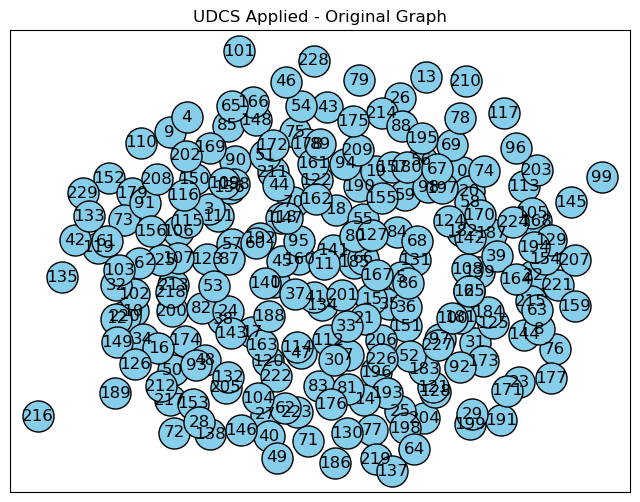


UDCS Matching Edges are:  []

Possible Flippable Edges are : []

Building defensive alliance by flipping atmost 24 edges is not possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (3, {'upper_bound': 0}), (15, {'upper_bound': 0}), (17, {'upper_bound': 0}), (23, {'upper_bound': 0}), (29, {'upper_bound': 0}), (41, {'upper_bound': 0}), (43, {'upper_bound': 2}), (55, {'upper_bound': 0}), (62, {'upper_bound': 3}), (68, {'upper_bound': 0}), (81, {'upper_bound': 5}), (83, {'upper_bound': 0}), (84, {'upper_bound': 1}), (86, {'upper_bound': 0}), (91, {'upper_bound': 0}), (107, {'upper_bound': 0}), (117, {'upper_bound': 4}), (126, {'upper_bound': 4}), (127, {'upper_bound': 3}), (144, {'upper_bound': 0}), (168, {'upper_bound': 0}), (170, {'upper_bound': 4}), (175, {'upper_bound': 1}), (179, {'upper_bound': 0}), (193, {'upper_bound': 1}), (197, {'upper_bound': 2}), (204, {'upper_bound': 2}), (211, {'upper_bound': 3}), (220, {'upper_bound': 0}), (225, {'upper_bound': 1}), (2, 

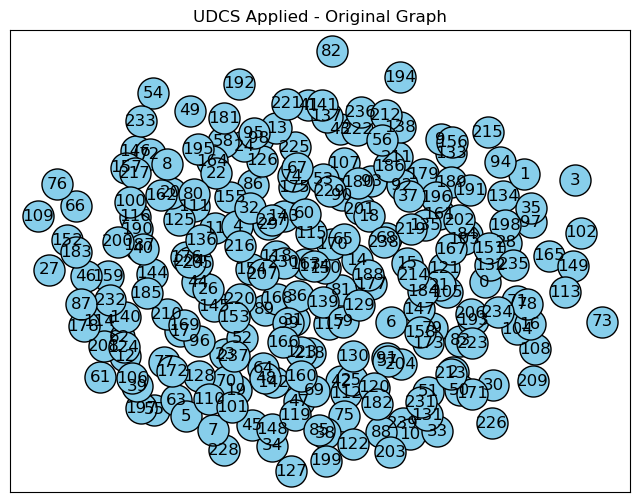


UDCS Matching Edges are:  []

Possible Flippable Edges are : []

Building defensive alliance by flipping atmost 25 edges is not possible

Graph with Upper Degree Constraints:
[(0, {'upper_bound': 0}), (25, {'upper_bound': 0}), (52, {'upper_bound': 1}), (55, {'upper_bound': 0}), (59, {'upper_bound': 4}), (65, {'upper_bound': 3}), (106, {'upper_bound': 0}), (107, {'upper_bound': 4}), (118, {'upper_bound': 4}), (119, {'upper_bound': 2}), (138, {'upper_bound': 3}), (147, {'upper_bound': 0}), (148, {'upper_bound': 1}), (152, {'upper_bound': 0}), (159, {'upper_bound': 4}), (176, {'upper_bound': 0}), (197, {'upper_bound': 2}), (201, {'upper_bound': 0}), (220, {'upper_bound': 2}), (227, {'upper_bound': 2}), (233, {'upper_bound': 0}), (244, {'upper_bound': 0}), (2, {'upper_bound': 1}), (1, {'upper_bound': 0}), (16, {'upper_bound': 3}), (51, {'upper_bound': 0}), (54, {'upper_bound': 0}), (62, {'upper_bound': 1}), (63, {'upper_bound': 0}), (78, {'upper_bound': 3}), (92, {'upper_bound': 0}), (104

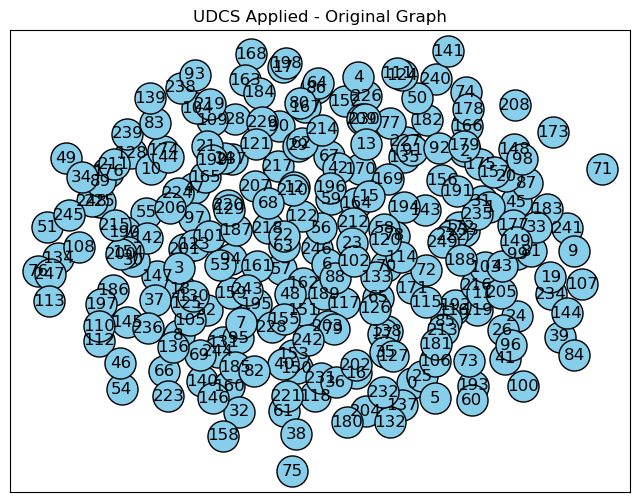


UDCS Matching Edges are:  []

Possible Flippable Edges are : []

Building defensive alliance by flipping atmost 26 edges is not possible


In [7]:

# # Create the graph
# file_path = r"/Users/mac/Desktop/Desktop/RCS_Signed_Graph/Meeting_4/graph_test_files/test2.txt"
# # getting the vertex which has to be check for UDCS from user
# # Get input from the user
# input_string = input("Enter a vertex set values separated by spaces to check Def.Alli: ")

# # Split the input string into a list of values
# input_list = input_string.split()

# # Convert the list of strings to a list of integers (or floats, if desired)
# d = [int(x) for x in input_list]  # Use int() for integers, float() for floats
    
# k = int(input("Enter number of edges to flip: "))

# # start time recorded
# start_time = time.monotonic()

# # here graph means signed graph edge set. original_graph means same unsigned graph edge set.
# graph, original_graph  = read_signed_graph_from_file(file_path) 
# n = len(graph)
# case_type = "file_type"
# run_building_defensive_alliance(graph, original_graph, start_time, d, k, n, case_type)


#################################################################################

nodes_to_check = 10
initial_avg_degree = 2
max_nodes_to_check = int(input("Please enter maximum number of nodes wanted to check: "))

print("\nCase 1: Same Vertex set and Same number of flip value")
print("\nCase 2: Vertex set will increase by half of the previous set and number of flip value will increase by 1")
case = int(input("Please enter whcih case want to check: "))

d = [1,2,3,4]
k = 2

while(nodes_to_check <= max_nodes_to_check):
    
    num_nodes = nodes_to_check
    avg_degree = initial_avg_degree
    G = erdos_renyi_signed_graph(num_nodes, avg_degree)
    graph, original_graph = create_graph_from_random_graph(G)
    start_time = time.monotonic()
        
    if case == 1:
        case_type = "case1"
        run_building_defensive_alliance(graph, original_graph, start_time, d, k, num_nodes, case_type)
    else:
        case_type = "case2"
        run_building_defensive_alliance(graph, original_graph, start_time, d, k, num_nodes, case_type)
    
        for i in range(0,math.floor(len(d)/2)):
            d.append(d[-1]+1)
        k = k+1
    
    
    initial_avg_degree = initial_avg_degree + 2 
    nodes_to_check = nodes_to_check + 10